In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model,model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import librosa as lb
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  

In [2]:
a=pd.read_csv('Final_data.csv')
a.head()
#a.shape
#a.columns

,Labels,Source,Path
0,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...
1,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...
2,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...
3,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...
4,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...


In [3]:
df=pd.DataFrame(columns=['Feature'])
c=0
for index,path in enumerate(a.Path):
    
    data,s_rate=lb.load(path,offset=0.5,sr=44100,duration=2.5,res_type='kaiser_fast')
    sample_rate=np.array(s_rate)
    mfcc=np.mean(lb.feature.mfcc(y=data,sr=sample_rate,n_mfcc=13),axis=0)
    df.loc[c]=[mfcc]
    c+=1

print(len(df))
df.head()
    
    
    

12162


,Feature
0,"[-11.113932, -7.215754, -6.21919, -5.9265437, ..."
1,"[-24.449831, -22.465742, -22.928043, -23.24380..."
2,"[-25.000114, -24.520254, -24.178185, -23.84745..."
3,"[-1.529839, -4.3334365, -12.285237, -13.083024..."
4,"[-22.458635, -22.467834, -25.88436, -27.827044..."


In [4]:
df.values.tolist()
df.head()

,Feature
0,"[-11.113932, -7.215754, -6.21919, -5.9265437, ..."
1,"[-24.449831, -22.465742, -22.928043, -23.24380..."
2,"[-25.000114, -24.520254, -24.178185, -23.84745..."
3,"[-1.529839, -4.3334365, -12.285237, -13.083024..."
4,"[-22.458635, -22.467834, -25.88436, -27.827044..."


In [5]:
#df=pd.concat([a,pd.DataFrame(df['Feature'].values.tolist())],axis=1)
#d=pd.concat([a,df],axis=1)
d=pd.concat([a,pd.DataFrame(df['Feature'].values.tolist())],axis=1)
#d=pd.concat([d.iloc[:,0:3],d.iloc[:,5:-1]])
d.head()
#df.head()

,Labels,Source,Path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...,-11.113932,-7.215754,-6.219190,-5.926544,-5.850418,-4.808960,-2.513001,...,-4.088852,-5.023863,-5.254715,-5.234095,-5.310306,-5.621665,-6.072197,-6.611348,-2.509089,1.964608
1,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...,-24.449831,-22.465742,-22.928043,-23.243809,-22.926605,-23.432241,-14.830003,...,-22.627258,-22.633406,-22.511599,-24.300159,-24.496813,-22.895985,-23.511509,-24.342152,-24.530264,-25.457798
2,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...,-25.000114,-24.520254,-24.178185,-23.847450,-15.182783,-10.732484,-8.681472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...,-1.529839,-4.333436,-12.285237,-13.083024,-12.041327,-11.819768,-9.414147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male angry,SAVEE,E:\Kaggle\Audio Emo Classifier\SAVEE\ALL\DC_a0...,-22.458635,-22.467834,-25.884359,-27.827044,-27.593533,-26.666508,-18.659023,...,-25.291666,-25.854910,-26.821350,-25.436453,-24.179941,-23.281618,-24.167494,-25.228062,-25.902941,-25.589966


In [6]:
#Replace NaN values : Imputation

#from sklearn.preprocessing import Imputer
#impute=Imputer(missing_values='NaN',strategy='mean',axis=0)
#X=d.iloc[:,:-1].values
#impute=impute.fit(X[:,3:219])
#X[:,3:219]=impute.transform(X[:,3:219])
#print(type(X))
#print(X.shape)

d=d.fillna(d.mean())

In [7]:
x_train,x_test,y_train,y_test=train_test_split(d.drop(['Labels','Source','Path'],axis=1),d.Labels,test_size=0.25,shuffle=True,random_state=42)
x_train=np.array((x_train-np.mean(x_train,axis=0))/np.std(x_train,axis=0))
x_test=np.array((x_test-np.mean(x_test,axis=0))/np.std(x_test,axis=0))
print(x_train.shape)
print(x_train[10:20])

(9121, 216)
[[ 2.72255035e-01  1.02475164e-01 -1.36964244e-01 ... -1.94444655e-03
  -1.06358742e-03 -1.19940686e-03]
 [-2.71913018e+00 -2.90742174e+00 -2.49479566e+00 ... -4.77297093e-01
   2.87396471e-01  9.09184167e-01]
 [ 2.36722291e-02 -5.74048330e-02 -4.92318571e-02 ... -1.94444655e-03
  -1.06358742e-03 -1.19940686e-03]
 ...
 [ 1.10212258e+00  1.02823997e+00  1.08183141e+00 ... -1.94444655e-03
  -1.06358742e-03 -1.19940686e-03]
 [-3.45115977e+00 -3.50269079e+00 -3.48207719e+00 ... -1.48478127e+00
  -1.42501112e+00 -1.56646326e+00]
 [ 3.25519820e-01  3.79768842e-01  6.27509201e-01 ... -1.94444655e-03
  -1.06358742e-03 -1.19940686e-03]]


In [8]:
y_train=np.array(y_train)
y_test=np.array(y_test)

l=LabelEncoder()
y_train=np_utils.to_categorical(l.fit_transform(y_train.astype('str')))

In [35]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [9]:
y_test=np_utils.to_categorical(l.fit_transform(y_test.astype('str')))

In [10]:
filename = 'Labels'
outfile = open(filename,'wb')
pickle.dump(l,outfile)
outfile.close()

In [18]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_train.shape

(9121, 216, 1)

In [19]:
y_train.shape

(9121, 22)

In [48]:
model=Sequential()

model.add(Conv1D(256,8,padding='same',input_shape=(x_train.shape[1],1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(256,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(128,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(64,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv1D(64,8,padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(32,8,padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(32,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(16,8,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(22)) #output classes
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_83 (Conv1D)           (None, 216, 256)          2304      
_________________________________________________________________
activation_91 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 216, 256)          1024      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 27, 256)           0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 27, 256)           524544    
_________________________________________________________________
activation_92 (Activation)   (None, 27, 256)           0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 27, 256)           1024      
__________

In [49]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,verbose=1,epochs=100,batch_size=16,validation_data=(x_test,y_test))

Train on 9121 samples, validate on 3041 samples
Epoch 1/100
9121/9121 [==============================] - 16s 2ms/step - loss: 2.4630 - acc: 0.2146 - val_loss: 2.2621 - val_acc: 0.2246
Epoch 2/100
9121/9121 [==============================] - 11s 1ms/step - loss: 2.1190 - acc: 0.2716 - val_loss: 1.9094 - val_acc: 0.3075
Epoch 3/100
9121/9121 [==============================] - 12s 1ms/step - loss: 2.0503 - acc: 0.2766 - val_loss: 2.2292 - val_acc: 0.2272
Epoch 4/100
9121/9121 [==============================] - 11s 1ms/step - loss: 1.9661 - acc: 0.3099 - val_loss: 2.0233 - val_acc: 0.2992
Epoch 5/100
9121/9121 [==============================] - 11s 1ms/step - loss: 1.9466 - acc: 0.3122 - val_loss: 1.9204 - val_acc: 0.3269
Epoch 6/100
9121/9121 [==============================] - 12s 1ms/step - loss: 1.9003 - acc: 0.3293 - val_loss: 1.8126 - val_acc: 0.3568
Epoch 7/100
9121/9121 [==============================] - 12s 1ms/step - loss: 1.8425 - acc: 0.3640 - val_loss: 1.8732 - val_acc: 0.3624


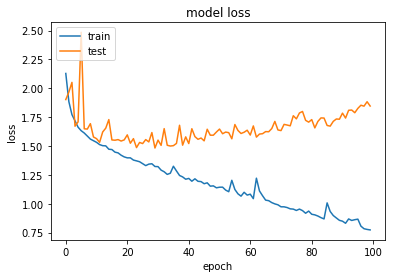

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()